### Importazione librerie

In [53]:
import pandas as pd
import numpy as np
import ccxt
from ta.volatility import AverageTrueRange, BollingerBands
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD, SMAIndicator, EMAIndicator
from ta.volume import OnBalanceVolumeIndicator
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import lightgbm as lgb
import warnings
import time
import matplotlib.pyplot as plt
import itertools
import requests
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

### Raccolta dati
Utilizziamo la funzione download_and_plot per scaricare i dati di Bitcoin da Bybit per il 2024 con timeframe di 1 minuto e li salviamo in un DataFrame.

In [26]:
def download_and_plot(cryptos, market, timeframe_download, start_date, end_date, plot):
    exchange_class = getattr(ccxt, market)
    exchange = exchange_class()
    exchange.load_markets()
    cryptos_pairs = [f"{crypto}/USDT" for crypto in cryptos]
    start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)
    data_frames = {}
    for pair in cryptos_pairs:
        if pair not in exchange.markets:
            raise ValueError(f"Il mercato {pair} non è disponibile su {market}.")
        print(f"Scarico i dati per {pair} dal {start_date} al {end_date}...")
        ohlcv = []
        since = start_timestamp
        while since < end_timestamp:
            batch = exchange.fetch_ohlcv(pair, timeframe_download, since)
            if not batch:
                break
            ohlcv.extend(batch)
            since = batch[-1][0] + 1
            time.sleep(exchange.rateLimit / 1000)
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        df = df[df.index <= pd.Timestamp(end_date)]
        data_frames[pair] = df
    return {k.replace('/USDT', ''): v for k, v in data_frames.items()}

In [27]:
# # Parametri per il download
# cryptos = ['BTC']
# market = 'bybit'
# timeframe_download = '1m'
# start_date = '2024-01-01'
# end_date = '2025-01-01'
# plot = False  # Imposta a True se vuoi visualizzare i grafici

# # Scarica i dati
# data = download_and_plot(cryptos, market, timeframe_download, start_date, end_date, plot)
# btc_df = data['BTC']
# btc_df

btc_df = pd.read_csv('Bitcoin (USDT) arricchito 2024 timeframe 5m.csv')
btc_df.set_index('timestamp', inplace=True)
btc_df.index = pd.to_datetime(btc_df.index)
btc_df

open      high       low     close     volume  \
timestamp                                                                
2024-04-19 00:00:00  63470.09  63470.09  63272.60  63283.05  171.66048   
2024-04-19 00:05:00  63283.05  63283.05  63072.99  63089.99  129.03663   
2024-04-19 00:10:00  63090.00  63090.00  62912.64  62913.99  209.10677   
2024-04-19 00:15:00  62914.00  63073.00  62913.99  63068.00  123.27576   
2024-04-19 00:20:00  63068.00  63106.57  62990.95  62992.11   56.42708   
...                       ...       ...       ...       ...        ...   
2024-12-31 23:35:00  93546.03  93546.03  93456.02  93464.26   37.27614   
2024-12-31 23:40:00  93464.27  93504.00  93456.00  93490.87   23.44102   
2024-12-31 23:45:00  93490.86  93544.50  93484.30  93544.49   23.00051   
2024-12-31 23:50:00  93544.49  93702.15  93544.49  93646.96   20.99684   
2024-12-31 23:55:00  93646.97  93676.98  93576.00  93576.00   17.03553   

                      notional_-5   notional_-4   notional_-3   notional_-2  \
timestamp                                                                     
2024-04-19 00:00:00  2.805868e+08  2.546757e+08  2.235747e+08  1.712686e+08   
2024-04-19 00:05:00  2.979414e+08  2.626244e+08  2.317270e+08  1.866406e+08   
2024-04-19 00:10:00  3.093996e+08  2.624514e+08  2.300250e+08  1.892556e+08   
2024-04-19 00:15:00  3.168050e+08  2.667421e+08  2.336174e+08  1.932235e+08   
2024-04-19 00:20:00  3.300506e+08  2.808887e+08  2.477095e+08  2.006171e+08   
...                           ...           ...           ...           ...   
2024-12-31 23:35:00  8.928054e+08  7.590884e+08  4.991608e+08  3.300921e+08   
2024-12-31 23:40:00  8.939847e+08  7.628307e+08  5.104306e+08  3.353413e+08   
2024-12-31 23:45:00  8.940680e+08  7.583909e+08  5.041382e+08  3.324905e+08   
2024-12-31 23:50:00  8.882012e+08  7.544450e+08  4.935072e+08  3.229468e+08   
2024-12-31 23:55:00  8.600473e+08  7.434125e+08  4.690769e+08  3.144676e+08   

                      notional_-1    notional_1    notional_2    notional_3  \
timestamp                                                                     
2024-04-19 00:00:00  8.151701e+07  8.958049e+07  2.323875e+08  2.885844e+08   
2024-04-19 00:05:00  8.880829e+07  7.741155e+07  2.146845e+08  2.813204e+08   
2024-04-19 00:10:00  8.843862e+07  7.034354e+07  1.965954e+08  2.765930e+08   
2024-04-19 00:15:00  9.231861e+07  7.493420e+07  1.840083e+08  2.711391e+08   
2024-04-19 00:20:00  1.016706e+08  7.919234e+07  2.027902e+08  2.755209e+08   
...                           ...           ...           ...           ...   
2024-12-31 23:35:00  1.791560e+08  9.927997e+07  1.716579e+08  2.532281e+08   
2024-12-31 23:40:00  1.824000e+08  9.365534e+07  1.730503e+08  2.493083e+08   
2024-12-31 23:45:00  1.801727e+08  8.778805e+07  1.693768e+08  2.473854e+08   
2024-12-31 23:50:00  1.728211e+08  9.540240e+07  1.716078e+08  2.508386e+08   
2024-12-31 23:55:00  1.684542e+08  1.035354e+08  1.819212e+08  2.618028e+08   

                       notional_4    notional_5  sum_open_interest_value  \
timestamp                                                                  
2024-04-19 00:00:00  3.980131e+08  4.338895e+08             4.291016e+09   
2024-04-19 00:05:00  3.904839e+08  4.277976e+08             4.282146e+09   
2024-04-19 00:10:00  3.623605e+08  4.223972e+08             4.272457e+09   
2024-04-19 00:15:00  3.150917e+08  4.182899e+08             4.264116e+09   
2024-04-19 00:20:00  3.523499e+08  4.187225e+08             4.272201e+09   
...                           ...           ...                      ...   
2024-12-31 23:35:00  3.071396e+08  3.720481e+08             8.535339e+09   
2024-12-31 23:40:00  3.060481e+08  3.639250e+08             8.527129e+09   
2024-12-31 23:45:00  3.007457e+08  3.583649e+08             8.529586e+09   
2024-12-31 23:50:00  3.047005e+08  3.694190e+08             8.534817e+09   
2024-12-31 23:55:00  3.167798e+08  3.829981e+08             8.541648e+09   

                 

### Integrazione dati on-chain da Coinmetrics

In [28]:
# # Definisci le metriche on-chain da scaricare
# metrics = "AdrActCnt,TxCnt,FeeTotUSD,SplyCur"  # Puoi aggiungere altre metriche qui

# frequency = "1d"  # Frequenza giornaliera

# # URL dell’API Community di CoinMetrics
# url = f"https://community-api.coinmetrics.io/v4/timeseries/asset-metrics?assets=btc&metrics={metrics}&start_time={start_date}&end_time={end_date}&frequency={frequency}"

# # Esegui la richiesta HTTP
# response = requests.get(url)
# data = response.json()

# # Converti i dati in un DataFrame
# df_onchain = pd.DataFrame(data['data'])
# df_onchain['time'] = pd.to_datetime(df_onchain['time'])

# # Rimuovi il fuso orario dall'indice di df_onchain
# df_onchain['time'] = df_onchain['time'].dt.tz_localize(None)

# # Imposta 'time' come indice
# df_onchain.set_index('time', inplace=True)

# # Ordina il tuo dataset per timestamp
# btc_df = btc_df.sort_index()

# # Unisci i dati on-chain a btc_df usando merge_asof
# for metric in metrics.split(','):
#     btc_df = pd.merge_asof(
#         btc_df,
#         df_onchain[[metric]],
#         left_index=True,
#         right_index=True,
#         direction='backward',  # Usa il valore on-chain più recente disponibile
#         tolerance=pd.Timedelta(days=1)  # Tolleranza per dati giornalieri
#     )

# # Rinomina le colonne per maggiore chiarezza (opzionale)
# btc_df.rename(columns={
#     'AdrActCnt': 'onchain_active_addresses',
#     'TxCnt': 'onchain_transaction_count',
#     'FeeTotUSD': 'onchain_total_fees_usd',
#     'SplyCur': 'onchain_circulating_supply'
# }, inplace=True)

# # Visualizza il risultato
# print("Dataset con nuove colonne on-chain:")
# btc_df.dropna(inplace=True)
# btc_df

In [29]:
# btc_df['onchain_active_addresses'] = btc_df['onchain_active_addresses'].astype(int)
# btc_df['onchain_transaction_count'] = btc_df['onchain_transaction_count'].astype(int)
# btc_df['onchain_total_fees_usd'] = btc_df['onchain_total_fees_usd'].astype(float)
# btc_df['onchain_circulating_supply'] = btc_df['onchain_circulating_supply'].astype(float)

# btc_df.dtypes

### Filtro il dataset tenendo solo una parte dei dati

In [30]:
btc_df = btc_df.iloc[:]
btc_df

open      high       low     close     volume  \
timestamp                                                                
2024-04-19 00:00:00  63470.09  63470.09  63272.60  63283.05  171.66048   
2024-04-19 00:05:00  63283.05  63283.05  63072.99  63089.99  129.03663   
2024-04-19 00:10:00  63090.00  63090.00  62912.64  62913.99  209.10677   
2024-04-19 00:15:00  62914.00  63073.00  62913.99  63068.00  123.27576   
2024-04-19 00:20:00  63068.00  63106.57  62990.95  62992.11   56.42708   
...                       ...       ...       ...       ...        ...   
2024-12-31 23:35:00  93546.03  93546.03  93456.02  93464.26   37.27614   
2024-12-31 23:40:00  93464.27  93504.00  93456.00  93490.87   23.44102   
2024-12-31 23:45:00  93490.86  93544.50  93484.30  93544.49   23.00051   
2024-12-31 23:50:00  93544.49  93702.15  93544.49  93646.96   20.99684   
2024-12-31 23:55:00  93646.97  93676.98  93576.00  93576.00   17.03553   

                      notional_-5   notional_-4   notional_-3   notional_-2  \
timestamp                                                                     
2024-04-19 00:00:00  2.805868e+08  2.546757e+08  2.235747e+08  1.712686e+08   
2024-04-19 00:05:00  2.979414e+08  2.626244e+08  2.317270e+08  1.866406e+08   
2024-04-19 00:10:00  3.093996e+08  2.624514e+08  2.300250e+08  1.892556e+08   
2024-04-19 00:15:00  3.168050e+08  2.667421e+08  2.336174e+08  1.932235e+08   
2024-04-19 00:20:00  3.300506e+08  2.808887e+08  2.477095e+08  2.006171e+08   
...                           ...           ...           ...           ...   
2024-12-31 23:35:00  8.928054e+08  7.590884e+08  4.991608e+08  3.300921e+08   
2024-12-31 23:40:00  8.939847e+08  7.628307e+08  5.104306e+08  3.353413e+08   
2024-12-31 23:45:00  8.940680e+08  7.583909e+08  5.041382e+08  3.324905e+08   
2024-12-31 23:50:00  8.882012e+08  7.544450e+08  4.935072e+08  3.229468e+08   
2024-12-31 23:55:00  8.600473e+08  7.434125e+08  4.690769e+08  3.144676e+08   

                      notional_-1    notional_1    notional_2    notional_3  \
timestamp                                                                     
2024-04-19 00:00:00  8.151701e+07  8.958049e+07  2.323875e+08  2.885844e+08   
2024-04-19 00:05:00  8.880829e+07  7.741155e+07  2.146845e+08  2.813204e+08   
2024-04-19 00:10:00  8.843862e+07  7.034354e+07  1.965954e+08  2.765930e+08   
2024-04-19 00:15:00  9.231861e+07  7.493420e+07  1.840083e+08  2.711391e+08   
2024-04-19 00:20:00  1.016706e+08  7.919234e+07  2.027902e+08  2.755209e+08   
...                           ...           ...           ...           ...   
2024-12-31 23:35:00  1.791560e+08  9.927997e+07  1.716579e+08  2.532281e+08   
2024-12-31 23:40:00  1.824000e+08  9.365534e+07  1.730503e+08  2.493083e+08   
2024-12-31 23:45:00  1.801727e+08  8.778805e+07  1.693768e+08  2.473854e+08   
2024-12-31 23:50:00  1.728211e+08  9.540240e+07  1.716078e+08  2.508386e+08   
2024-12-31 23:55:00  1.684542e+08  1.035354e+08  1.819212e+08  2.618028e+08   

                       notional_4    notional_5  sum_open_interest_value  \
timestamp                                                                  
2024-04-19 00:00:00  3.980131e+08  4.338895e+08             4.291016e+09   
2024-04-19 00:05:00  3.904839e+08  4.277976e+08             4.282146e+09   
2024-04-19 00:10:00  3.623605e+08  4.223972e+08             4.272457e+09   
2024-04-19 00:15:00  3.150917e+08  4.182899e+08             4.264116e+09   
2024-04-19 00:20:00  3.523499e+08  4.187225e+08             4.272201e+09   
...                           ...           ...                      ...   
2024-12-31 23:35:00  3.071396e+08  3.720481e+08             8.535339e+09   
2024-12-31 23:40:00  3.060481e+08  3.639250e+08             8.527129e+09   
2024-12-31 23:45:00  3.007457e+08  3.583649e+08             8.529586e+09   
2024-12-31 23:50:00  3.047005e+08  3.694190e+08             8.534817e+09   
2024-12-31 23:55:00  3.167798e+08  3.829981e+08             8.541648e+09   

                 

### Feature engineering
Calcoliamo le feature richieste: ATR, RSI, medie mobili semplici (SMA) ed esponenziali (EMA), deviazioni standard mobili, minimi e massimi mobili, sia sui prezzi che sulle variazioni percentuali. Aggiungiamo anche le derivate prima, seconda e terza.

In [31]:
def calculate_indicators_2(df, windows, atr_windows, rsi_windows, macd_windows=[12, 26, 9], bb_windows=[20], stoch_windows=[14], lag_windows=[1, 2, 5]):
    price_types = ['open', 'high', 'low', 'close']

    # --- Feature di base sui prezzi ---
    # Variazione percentuale
    for price_type in price_types:
        df[f'pct_change_{price_type}'] = df[price_type].pct_change()

    # ATR
    for atr_window in atr_windows:
        df[f'ATR_{atr_window}'] = AverageTrueRange(df['high'], df['low'], df['close'], window=atr_window).average_true_range()

    # RSI (solo per close)
    for rsi_window in rsi_windows:
        for price_type in price_types:
            df[f'RSI_{price_type}_{rsi_window}'] = RSIIndicator(df[price_type], window=rsi_window).rsi()

    # MACD (solo per close)
    macd = MACD(df['close'], window_slow=macd_windows[1], window_fast=macd_windows[0], window_sign=macd_windows[2])
    df['MACD_close'] = macd.macd()
    df['MACD_signal_close'] = macd.macd_signal()
    df['MACD_diff_close'] = macd.macd_diff()

    # Bollinger Bands (solo per close)
    for bb_window in bb_windows:
        bb = BollingerBands(df['close'], window=bb_window, window_dev=2)
        df[f'BB_high_close_{bb_window}'] = bb.bollinger_hband()
        df[f'BB_low_close_{bb_window}'] = bb.bollinger_lband()
        df[f'BB_mid_close_{bb_window}'] = bb.bollinger_mavg()

    # Stochastic Oscillator
    for stoch_window in stoch_windows:
        stoch = StochasticOscillator(df['high'], df['low'], df['close'], window=stoch_window)
        df[f'Stoch_k_{stoch_window}'] = stoch.stoch()
        df[f'Stoch_d_{stoch_window}'] = stoch.stoch_signal()

    # On-Balance Volume
    df['OBV'] = OnBalanceVolumeIndicator(df['close'], df['volume']).on_balance_volume()

    # Volume medio mobile
    for window in windows:
        df[f'SMA_volume_{window}'] = df['volume'].rolling(window=window).mean()

    # Accumulation/Distribution Line
    df['ADL'] = (df['close'] - df['low'] - (df['high'] - df['close'])) / (df['high'] - df['low'] + 1e-8) * df['volume']
    df['ADL'] = df['ADL'].cumsum()

    # Chaikin Money Flow
    for window in windows:
        mfm = ((df['close'] - df['low']) - (df['high'] - df['close'])) / (df['high'] - df['low'] + 1e-8)
        mfv = mfm * df['volume']
        df[f'CMF_{window}'] = mfv.rolling(window=window).sum() / df['volume'].rolling(window=window).sum()

    # Volatilità realizzata
    for window in windows:
        df[f'volatility_{window}'] = df['pct_change_close'].rolling(window=window).std()

    # Feature temporali
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day

    # Volume profile
    price_bins = np.linspace(df['low'].min(), df['high'].max(), num=100)
    df['price_bin'] = np.digitize(df['close'], price_bins)
    volume_profile = df.groupby('price_bin')['volume'].sum()
    df['volume_profile'] = df['price_bin'].map(volume_profile)

    # Lag features
    for lag in lag_windows:
        for price_type in price_types:
            df[f'{price_type}_lag_{lag}'] = df[price_type].shift(lag)
            df[f'pct_change_{price_type}_lag_{lag}'] = df[f'pct_change_{price_type}'].shift(lag)

    # SMA, EMA, STD, MIN, MAX (solo per close e volume)
    for window in windows:
        df[f'SMA_close_{window}'] = df['close'].rolling(window=window).mean()
        df[f'EMA_close_{window}'] = df['close'].ewm(span=window, adjust=False).mean()
        df[f'STD_close_{window}'] = df['close'].rolling(window=window).std()
        df[f'MIN_close_{window}'] = df['close'].rolling(window=window).min()
        df[f'MAX_close_{window}'] = df['close'].rolling(window=window).max()

        df[f'SMA_volume_{window}'] = df['volume'].rolling(window=window).mean()
        df[f'EMA_volume_{window}'] = df['volume'].ewm(span=window, adjust=False).mean()

        df[f'SMA_PCT_close_{window}'] = df['pct_change_close'].rolling(window=window).mean()
        df[f'EMA_PCT_close_{window}'] = df['pct_change_close'].ewm(span=window, adjust=False).mean()
        df[f'STD_PCT_close_{window}'] = df['pct_change_close'].rolling(window=window).std()

    # --- Feature basate sull'order book ---
    # Order book imbalance (vero, basato sui dati cumulativi)
    df['order_book_imbalance'] = (df['notional_-5'] - df['notional_5']) / (df['notional_-5'] + df['notional_5'] + 1e-8)

    # Rapporti bid/ask a diversi livelli
    for level in [1, 2, 3, 4, 5]:
        df[f'bid_ask_ratio_{level}'] = df[f'notional_-{level}'] / (df[f'notional_{level}'] + 1e-8)

    # Slope dell'order book (variazione della profondità cumulativa)
    df['bid_slope'] = (df['notional_-1'] - df['notional_-5']) / 4  # Da -1% a -5%, 4 step
    df['ask_slope'] = (df['notional_5'] - df['notional_1']) / 4   # Da 1% a 5%, 4 step

    # --- Feature basate sui rapporti long/short ---
    for window in windows:
        df[f'SMA_toptrader_ls_ratio_{window}'] = df['sum_toptrader_long_short_ratio'].rolling(window=window).mean()
        df[f'SMA_taker_ls_vol_ratio_{window}'] = df['sum_taker_long_short_vol_ratio'].rolling(window=window).mean()

    df['delta_toptrader_ls_ratio'] = df['sum_toptrader_long_short_ratio'].diff()
    df['delta_taker_ls_vol_ratio'] = df['sum_taker_long_short_vol_ratio'].diff()

    # --- Feature basate sull'open interest ---
    df['delta_open_interest'] = df['sum_open_interest_value'].diff()
    df['oi_volume_ratio'] = df['sum_open_interest_value'] / (df['volume'] + 1e-8)

    # --- Feature di interazione ---
    df['bid_depth_volume'] = df['notional_-5'] * df['volume']
    df['ask_depth_volume'] = df['notional_5'] * df['volume']
    for rsi in rsi_windows:
        for price_type in price_types:
            df[f'RSI_imbalance_{price_type}_{rsi}'] = df[f'RSI_{price_type}_{rsi}'] * df['order_book_imbalance']

    for window in windows:
        df[f'volatility_oi_{window}'] = df[f'volatility_{window}'] * df['sum_open_interest_value']

    # --- Feature temporali cicliche ---
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    # Derivate
    for feature in df.columns:
        if feature not in ['hour', 'day_of_week', 'day_of_month', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos']:
            df[f'first_derivative_{feature}'] = df[feature].diff()
            df[f'second_derivative_{feature}'] = df[feature].diff().diff()

    return df

In [32]:
# Parametri aggiornati
windows = [144, 288, 576]
atr_windows = [144, 288, 576]
rsi_windows = [144, 288, 576]
macd_windows = [144, 288, 576]
bb_windows = [144, 288, 576]
stoch_windows = [144, 288, 576]
lag_windows = [1, 2, 3, 144, 288, 576]

# Applica la funzione
btc_df = calculate_indicators_2(btc_df, windows, atr_windows, rsi_windows, macd_windows, bb_windows, stoch_windows, lag_windows)
btc_df = btc_df.dropna()
btc_df

open      high       low     close     volume  \
timestamp                                                                
2024-04-22 01:25:00  65587.98  65620.00  64908.39  64913.99  298.52350   
2024-04-22 01:30:00  64914.00  64968.75  64604.56  64910.00  589.93893   
2024-04-22 01:35:00  64910.01  64944.94  64650.01  64740.00  170.61011   
2024-04-22 01:40:00  64740.00  64858.63  64664.22  64792.99  134.46394   
2024-04-22 01:45:00  64793.00  64917.65  64706.25  64796.00   71.29653   
...                       ...       ...       ...       ...        ...   
2024-12-31 23:35:00  93546.03  93546.03  93456.02  93464.26   37.27614   
2024-12-31 23:40:00  93464.27  93504.00  93456.00  93490.87   23.44102   
2024-12-31 23:45:00  93490.86  93544.50  93484.30  93544.49   23.00051   
2024-12-31 23:50:00  93544.49  93702.15  93544.49  93646.96   20.99684   
2024-12-31 23:55:00  93646.97  93676.98  93576.00  93576.00   17.03553   

                      notional_-5   notional_-4   notional_-3   notional_-2  \
timestamp                                                                     
2024-04-22 01:25:00  3.944960e+08  3.057371e+08  2.419019e+08  1.624951e+08   
2024-04-22 01:30:00  4.248006e+08  3.586540e+08  2.775809e+08  2.029228e+08   
2024-04-22 01:35:00  4.336901e+08  3.783970e+08  2.876040e+08  2.061673e+08   
2024-04-22 01:40:00  4.773470e+08  3.902136e+08  2.975826e+08  2.205056e+08   
2024-04-22 01:45:00  4.685221e+08  3.903273e+08  2.989878e+08  2.221969e+08   
...                           ...           ...           ...           ...   
2024-12-31 23:35:00  8.928054e+08  7.590884e+08  4.991608e+08  3.300921e+08   
2024-12-31 23:40:00  8.939847e+08  7.628307e+08  5.104306e+08  3.353413e+08   
2024-12-31 23:45:00  8.940680e+08  7.583909e+08  5.041382e+08  3.324905e+08   
2024-12-31 23:50:00  8.882012e+08  7.544450e+08  4.935072e+08  3.229468e+08   
2024-12-31 23:55:00  8.600473e+08  7.434125e+08  4.690769e+08  3.144676e+08   

                      notional_-1  ...  \
timestamp                          ...   
2024-04-22 01:25:00  7.747681e+07  ...   
2024-04-22 01:30:00  8.402365e+07  ...   
2024-04-22 01:35:00  7.928718e+07  ...   
2024-04-22 01:40:00  9.708840e+07  ...   
2024-04-22 01:45:00  9.591874e+07  ...   
...                           ...  ...   
2024-12-31 23:35:00  1.791560e+08  ...   
2024-12-31 23:40:00  1.824000e+08  ...   
2024-12-31 23:45:00  1.801727e+08  ...   
2024-12-31 23:50:00  1.728211e+08  ...   
2024-12-31 23:55:00  1.684542e+08  ...   

                     first_derivative_RSI_imbalance_low_576  \
timestamp                                                     
2024-04-22 01:25:00                               -1.565368   
2024-04-22 01:30:00                                3.165909   
2024-04-22 01:35:00                                0.813737   
2024-04-22 01:40:00                                2.471379   
2024-04-22 01:45:00                               -0.390167   
...                                                     ...   
2024-12-31 23:35:00                                1.552962   
2024-12-31 23:40:00                                0.476204   
2024-12-31 23:45:00                                0.325088   
2024-12-31 23:50:00                               -0.724734   
2024-12-31 23:55:00                               -1.405742   

                     second_derivative_RSI_imbalance_low_576  \
timestamp                                                      
2024-04-22 01:25:00                                -0.691234   
2024-04-22 01:30:00                                 4.731276   
2024-04-22 01:35:00                                -2.352172   
2024-04-22 01:40:00                                 1.657642   
2024-04-22 01:45:00                                -2.861547   
...                                                      ...   
2024-12-31 23:35:00                                 2.264346   
2024-12-31 23:40:00                                -1.076758   
2024-12-31 23:45:00        

In [33]:
btc_df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'notional_-5', 'notional_-4',
       'notional_-3', 'notional_-2', 'notional_-1',
       ...
       'first_derivative_RSI_imbalance_low_576',
       'second_derivative_RSI_imbalance_low_576',
       'first_derivative_RSI_imbalance_close_576',
       'second_derivative_RSI_imbalance_close_576',
       'first_derivative_volatility_oi_144',
       'second_derivative_volatility_oi_144',
       'first_derivative_volatility_oi_288',
       'second_derivative_volatility_oi_288',
       'first_derivative_volatility_oi_576',
       'second_derivative_volatility_oi_576'],
      dtype='object', length=547)

### Preparazione dei dati
Raggruppiamo i dati per giorno, li mischiamo casualmente e li dividiamo in train, validation e test sets.

In [34]:
def prepare_data(df, F, train_size=0.7, val_size=0.2, seed=42):
    """
    Prepara i dati per il training dividendo casualmente in train, validation e test set.
    
    Args:
        df (pd.DataFrame): DataFrame contenente i dati con feature e colonna 'close'.
        F (int): Numero di minuti nel futuro per il target.
        train_size (float): Percentuale di dati per il training (default: 0.7).
        val_size (float): Percentuale di dati per la validation (default: 0.2).
        seed (int): Seme per la riproducibilità (default: 42).
    
    Returns:
        X_train, y_train, X_val, y_val, X_test, y_test: Suddivisioni dei dati.
    """
    test_size = 1 - train_size - val_size  # Calcola la percentuale per il test set
    
    # Target: variazione del prezzo dopo F candele
    y = df['close'].shift(-F) - df['close']  # Variazione del prezzo come target
    
    # Rimuovi le ultime F righe dove y è NaN
    X = df.iloc[:-F]  # Feature
    y = y.iloc[:-F]   # Target
    
    # Prima suddivisione: separa train+val da test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=seed, 
        shuffle=False
    )
    
    # Calcola la proporzione per train e val rispetto al set rimanente (train+val)
    train_proportion = train_size / (train_size + val_size)
    
    # Seconda suddivisione: separa train da validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, 
        train_size=train_proportion, 
        random_state=seed, 
        shuffle=False
    )
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [35]:
# Parametri regolabili
F = int(2*24*60/5)  # Numero di candele avanti da prevedere
train_size = 0.7  # 70% dei giorni rimanenti per il train
val_size = 0.15  # 20% dei giorni rimanenti per la validation
seed = 8

# Prepara i dati (assumendo che btc_df sia il DataFrame con i dati)
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(btc_df, F, train_size, val_size, seed)

# Controllo delle dimensioni
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (48893, 547), Validation: (10478, 547), Test: (10478, 547)


### Costruzione e addestramento dei modelli
Costruiamo e addestriamo un modello Random Forest e una rete neurale

#### Random forest

In [11]:
def train_random_forest_2(X_train, y_train, X_val, y_val, X_test, y_test):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5],
        'max_features': ['sqrt', 'log2', None]
    }
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=4, verbose=2)
    grid_search.fit(X_train, y_train)
    best_rf = grid_search.best_estimator_
    
    # Predizioni e metriche
    rf_pred = best_rf.predict(X_test)
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
    rf_mae = mean_absolute_error(y_test, rf_pred)
    rf_mape = mean_absolute_percentage_error(y_test, rf_pred)
    rf_direction_accuracy = np.mean(np.sign(rf_pred) == np.sign(y_test))
    
    print(f"Best Random Forest Params: {grid_search.best_params_}")
    print(f"Random Forest - RMSE: {rf_rmse:.4f}, MAE: {rf_mae:.4f}, MAPE: {rf_mape:.4f}")
    print(f"Random Forest Directional Accuracy: {rf_direction_accuracy:.4f}")
    
    # Feature importances
    importances = best_rf.feature_importances_
    importances_pct = 100.0 * (importances / importances.sum())
    feats_imp = pd.DataFrame({
        'feature': X_train.columns,
        'importance_pct': importances_pct
    }).sort_values('importance_pct', ascending=True)
    
    print("\nFeature Importances (valore percentuale):")
    print(feats_imp.sort_values('importance_pct', ascending=False))
    
    plt.figure(figsize=(8, 4))
    plt.barh(feats_imp['feature'], feats_imp['importance_pct'], color='skyblue')
    plt.xlabel('Feature Importance (%)')
    plt.title('Random Forest Feature Importances')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
    
    return best_rf, rf_pred, rf_rmse, rf_mae, rf_mape, rf_direction_accuracy

In [12]:
rf_model, rf_pred, rf_rmse, rf_mae, rf_mape, rf_direction_accuracy = train_random_forest_2(X_train, y_train, X_val, y_val, X_test, y_test)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


KeyboardInterrupt: 

#### Rete neurale

In [62]:
def train_neural_network_regressor_2(
    X_train, y_train, X_val, y_val, X_test, y_test,
    network_width=1024, network_depth=3, activation_function='relu',
    patience=5, epochs=10000, batch_size=32, monitor='val_loss', loss='mse'
):
    X_train_np = X_train
    y_train_np = y_train
    X_val_np = X_val
    y_val_np = y_val
    X_test_np = X_test
    y_test_np = y_test

    model = Sequential()
    model.add(InputLayer(input_shape=(X_train_np.shape[1],)))
    for _ in range(network_depth):
        model.add(Dense(network_width, activation=activation_function))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss=loss, metrics=['mae', 'mape'])
    early_stop = EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=True)

    history = model.fit(
        X_train_np, y_train_np,
        validation_data=(X_val_np, y_val_np),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )

    nn_pred = model.predict(X_test_np).flatten()
    nn_rmse = np.sqrt(mean_squared_error(y_test_np, nn_pred))
    nn_mae = mean_absolute_error(y_test_np, nn_pred)
    nn_mape = mean_absolute_percentage_error(y_test_np, nn_pred)
    nn_direction_accuracy = np.mean(np.sign(nn_pred) == np.sign(y_test_np))

    print(f"Neural Network - RMSE: {nn_rmse:.4f}, MAE: {nn_mae:.4f}, MAPE: {nn_mape:.4f}")
    print(f"Neural Network Directional Accuracy: {nn_direction_accuracy:.4f}")

    epochs_range = range(1, len(history.history['loss']) + 1)
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history.history['loss'], label='Train Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Loss durante l’Addestramento')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history.history['mae'], label='Train MAE')
    plt.plot(epochs_range, history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('MAE durante l’Addestramento')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history.history['mape'], label='Train MAPE')
    plt.plot(epochs_range, history.history['val_mape'], label='Validation MAPE')
    plt.xlabel('Epoch')
    plt.ylabel('MAPE')
    plt.title('MAPE durante l’Addestramento')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model, history, nn_pred, nn_rmse, nn_mae, nn_mape, nn_direction_accuracy

In [63]:
# Scalare X (come hai già fatto)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Scalare y
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

Epoch 1/10000
382/382 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - loss: 1.1806 - mae: 0.7031 - mape: 320.6599 - val_loss: 11.4944 - val_mae: 2.5713 - val_mape: 1062.1128
Epoch 2/10000
382/382 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 0.0986 - mae: 0.2358 - mape: 179.2722 - val_loss: 8.7870 - val_mae: 2.2648 - val_mape: 863.1605
Epoch 3/10000
382/382 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - loss: 0.0525 - mae: 0.1681 - mape: 150.4998 - val_loss: 9.7004 - val_mae: 2.3821 - val_mape: 944.0533
Epoch 4/10000
382/382 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - loss: 0.0369 - mae: 0.1416 - mape: 108.9035 - val_loss: 9.7718 - val_mae: 2.3964 - val_mape: 956.1935
Epoch 5/10000
382/382 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - loss: 0.0314 - mae: 0.1304 - mape: 124.1046 - val_loss: 10.4114 - val_mae: 2.4743 - val_mape: 991.8011
Epoch 6/10000
382/382 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - loss: 0.0246 - mae: 0.1162 - mape: 89.0787 - val_loss: 10.6237 - val_mae: 2.4965 - val_mape: 1002.3107
Epoch 7/10000
382/382 ━━━━━━━━

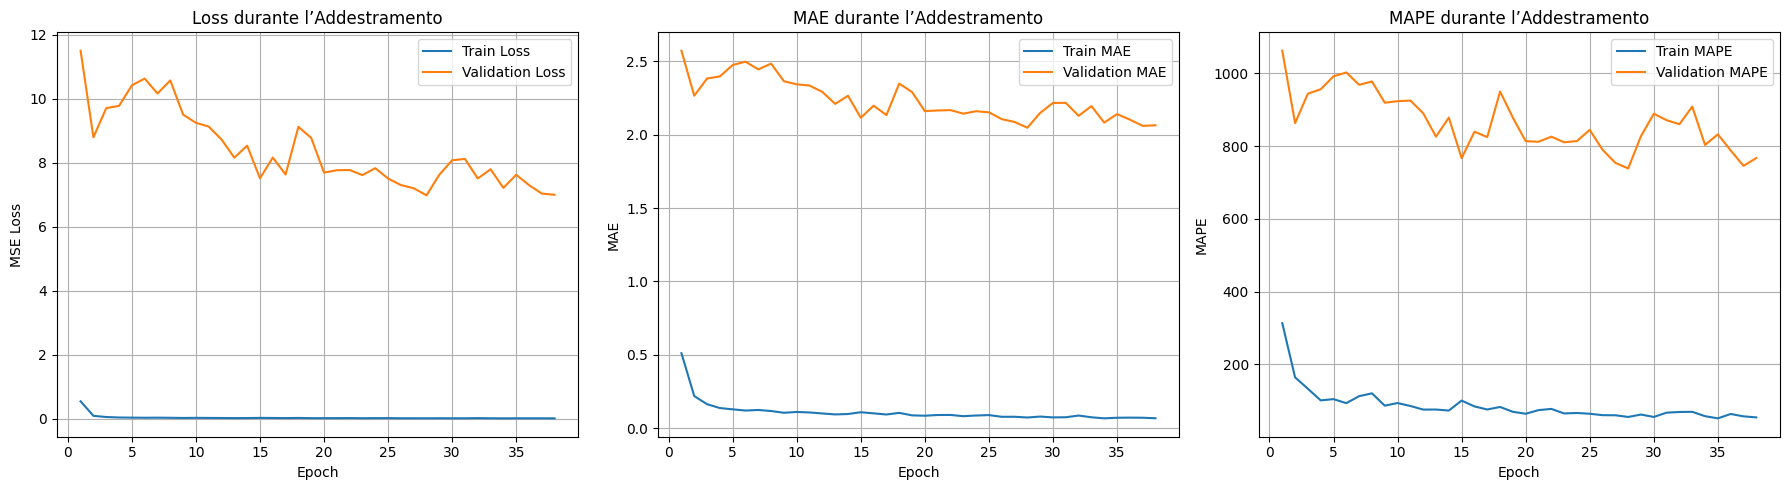

In [64]:
network_width=1024
network_depth=3
activation_function='relu'
patience=10
epochs=10000
batch_size=128
monitor='val_loss'
loss='mse'

nn_model, nn_history, nn_pred, nn_rmse, nn_mae, nn_mape, nn_direction_accuracy = train_neural_network_regressor_2(
    X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled, network_width, network_depth, activation_function,
    patience, epochs, batch_size, monitor, loss
)

In [ ]:
y_pred_scaled = nn_model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

#### LSTM

In [19]:
def create_sequences(X, y, lookback, forecast_horizon=1):
    X_seq, y_seq = [], []
    for i in range(lookback, len(X) - forecast_horizon):
        X_seq.append(X.iloc[i - lookback:i].values)
        y_seq.append(y.iloc[i + forecast_horizon])
    return np.array(X_seq), np.array(y_seq)

In [20]:
def train_lstm_model_2(
    X_train, y_train, X_val, y_val, X_test, y_test,
    lookback=60, forecast_horizon=F, lstm_units=50, num_layers=1,
    dropout_rate=0.2, dense_units=10, use_bidirectional=False,
    activation='tanh', recurrent_activation='sigmoid',
    epochs=100, batch_size=32, learning_rate=0.001, patience=10,
    optimizer='adam', loss_function='mse'
):
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, lookback, forecast_horizon)
    X_val_seq, y_val_seq = create_sequences(X_val, y_val, lookback, forecast_horizon)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, lookback, forecast_horizon)
    
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            if use_bidirectional:
                model.add(Bidirectional(LSTM(
                    units=lstm_units,
                    activation=activation,
                    recurrent_activation=recurrent_activation,
                    return_sequences=(num_layers > 1),
                    input_shape=(lookback, X_train.shape[1])
                )))
            else:
                model.add(LSTM(
                    units=lstm_units,
                    activation=activation,
                    recurrent_activation=recurrent_activation,
                    return_sequences=(num_layers > 1),
                    input_shape=(lookback, X_train.shape[1])
                ))
        else:
            if use_bidirectional:
                model.add(Bidirectional(LSTM(
                    units=lstm_units,
                    activation=activation,
                    recurrent_activation=recurrent_activation,
                    return_sequences=(i < num_layers - 1)
                )))
            else:
                model.add(LSTM(
                    units=lstm_units,
                    activation=activation,
                    recurrent_activation=recurrent_activation,
                    return_sequences=(i < num_layers - 1)
                ))
    
    model.add(Dropout(dropout_rate))
    if dense_units > 0:
        model.add(Dense(units=dense_units, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    opt = Adam(learning_rate=learning_rate) if optimizer.lower() == 'adam' else optimizer
    model.compile(optimizer=opt, loss=loss_function)

    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=2
    )

    lstm_pred = model.predict(X_test_seq).flatten()
    lstm_rmse = np.sqrt(mean_squared_error(y_test_seq, lstm_pred))
    lstm_mae = mean_absolute_error(y_test_seq, lstm_pred)
    lstm_mape = mean_absolute_percentage_error(y_test_seq, lstm_pred)
    lstm_direction_accuracy = np.mean(np.sign(lstm_pred) == np.sign(y_test_seq))

    print(f"LSTM - RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}, MAPE: {lstm_mape:.4f}")
    print(f"LSTM Directional Accuracy: {lstm_direction_accuracy:.4f}")

    return model, history, lstm_pred, y_test_seq, lstm_rmse, lstm_mae, lstm_mape, lstm_direction_accuracy

In [21]:
lookback=60
forecast_horizon=F
lstm_units=500
num_layers=2
dropout_rate=0.3
dense_units=10
use_bidirectional=False
activation='tanh'
recurrent_activation='sigmoid'
epochs=1000
batch_size=64
learning_rate=0.001
patience=10
optimizer='adam'
loss_function='mse'

lstm_model, lstm_history, lstm_pred, y_test_seq, lstm_rmse, lstm_mae, lstm_mape, lstm_direction_accuracy = train_lstm_model_2(
    X_train, y_train, X_val, y_val, X_test, y_test, lookback, forecast_horizon, lstm_units, num_layers, dropout_rate, dense_units, use_bidirectional, activation, recurrent_activation, epochs, batch_size, learning_rate, patience,
    optimizer, loss_function
)

Epoch 1/1000
464/464 - 846s - 2s/step - loss: 75236.7656 - val_loss: 35759.2852
Epoch 2/1000
464/464 - 900s - 2s/step - loss: 75231.7266 - val_loss: 35766.3789
Epoch 3/1000
464/464 - 857s - 2s/step - loss: 75227.1719 - val_loss: 35766.9648
Epoch 4/1000
464/464 - 793s - 2s/step - loss: 75231.0078 - val_loss: 35777.1406
Epoch 5/1000
464/464 - 830s - 2s/step - loss: 75232.7578 - val_loss: 35766.9922
Epoch 6/1000
464/464 - 896s - 2s/step - loss: 75227.9453 - val_loss: 35773.7812
Epoch 7/1000
464/464 - 907s - 2s/step - loss: 75230.6016 - val_loss: 35771.5859
Epoch 8/1000


KeyboardInterrupt: 

#### LGBM

In [65]:
# def train_lightgbm_2(X_train, y_train, X_val, y_val, X_test, y_test):
#     train_data = lgb.Dataset(X_train, label=y_train)
#     val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
#     params = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'boosting_type': 'gbdt',
#         'num_leaves': 31,
#         'learning_rate': 0.05,
#         'feature_fraction': 0.9
#     }
#     lgb_model = lgb.train(
#         params,
#         train_data,
#         num_boost_round=10000,
#         valid_sets=[val_data],
#         callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(10)]
#     )
#     lgb_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
#     lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
#     lgb_mae = mean_absolute_error(y_test, lgb_pred)
#     lgb_mape = mean_absolute_percentage_error(y_test, lgb_pred)
#     lgb_direction_accuracy = np.mean(np.sign(lgb_pred) == np.sign(y_test))

#     print(f"LightGBM - RMSE: {lgb_rmse:.4f}, MAE: {lgb_mae:.4f}, MAPE: {lgb_mape:.4f}")
#     print(f"LightGBM Directional Accuracy: {lgb_direction_accuracy:.4f}")

#     return lgb_model, lgb_pred, lgb_rmse, lgb_mae, lgb_mape, lgb_direction_accuracy

# Early stopping, best iteration is:
# [3879]	valid_0's rmse: 142.769
# LightGBM - RMSE: 143.7226, MAE: 102.0752, MAPE: 7238066441762.0635
# LightGBM Directional Accuracy: 0.8677

In [66]:
def train_lightgbm_optimized(X_train, y_train, X_val, y_val, X_test, y_test, param_grid, n_splits=5):
    best_model = None
    best_rmse = float('inf')
    best_directional_accuracy = 0
    best_idx = None
    best_combination = None

    # Definisci TimeSeriesSplit per la cross-validation temporale
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Calcola il numero totale di combinazioni
    total_combinations = len(list(itertools.product(*param_grid.values())))

    # Genera tutte le combinazioni di parametri
    keys, values = zip(*param_grid.items())
    for idx, combination in enumerate(itertools.product(*values), 1):
        params = dict(zip(keys, combination))

        # Estrai num_boost_round e stopping_rounds dalla griglia
        num_boost_round = params.pop('num_boost_round')
        stopping_rounds = params.pop('stopping_rounds')

        # Aggiungi parametri fissi
        params['objective'] = 'regression'
        params['metric'] = 'rmse'
        params['boosting_type'] = 'gbdt'

        # Stampa la combinazione corrente
        print(f"\nTesting combination {idx}/{total_combinations}:\n{params}\nnum_boost_round={num_boost_round}\nstopping_rounds={stopping_rounds}")

        # Liste per salvare le performance sui fold
        fold_rmses = []
        fold_directional_accuracies = []

        # Esegui la cross-validation temporale
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
            print(f"  Fold {fold}/{n_splits}")

            # Crea i subset di training e validation per il fold corrente
            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # Crea i dataset LightGBM
            train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
            val_data = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data)

            # Addestra il modello con early stopping
            model = lgb.train(
                params,
                train_data,
                num_boost_round=num_boost_round,
                valid_sets=[val_data],
                callbacks=[lgb.early_stopping(stopping_rounds=stopping_rounds), lgb.log_evaluation(10)]
            )

            # Calcola le metriche sul validation fold
            val_pred = model.predict(X_val_fold, num_iteration=model.best_iteration)
            val_rmse = np.sqrt(mean_squared_error(y_val_fold, val_pred))
            val_directional_accuracy = np.mean(np.sign(val_pred) == np.sign(y_val_fold))

            fold_rmses.append(val_rmse)
            fold_directional_accuracies.append(val_directional_accuracy)

            print(f"  Fold {fold} - Validation RMSE: {val_rmse:.4f}, Directional Accuracy: {val_directional_accuracy:.4f}")

        # Calcola la media delle performance sui fold
        mean_rmse = np.mean(fold_rmses)
        mean_directional_accuracy = np.mean(fold_directional_accuracies)

        # Stampa i risultati medi della combinazione
        print(f"Combination {idx}/{total_combinations} - Mean Validation RMSE: {mean_rmse:.4f}, Mean Directional Accuracy: {mean_directional_accuracy:.4f}")

        # Aggiorna il modello migliore se necessario
        if mean_directional_accuracy > best_directional_accuracy:
            best_directional_accuracy = mean_directional_accuracy
            best_rmse = mean_rmse
            best_model = model  # Salva l'ultimo modello del fold
            best_idx = idx
            best_combination = params.copy()
            best_combination['num_boost_round'] = num_boost_round
            best_combination['stopping_rounds'] = stopping_rounds

        print(f'Current best directional accuracy: {best_directional_accuracy}, with rmse {best_rmse}, idx {best_idx} and parameters {best_combination}')

    # Calcola le predizioni sui vari set con il modello migliore
    train_pred = best_model.predict(X_train, num_iteration=best_model.best_iteration)
    val_pred = best_model.predict(X_val, num_iteration=best_model.best_iteration)
    test_pred = best_model.predict(X_test, num_iteration=best_model.best_iteration)

    # Stampa i dettagli del miglior modello
    print(f'\nbest_idx: {best_idx}, '
          f'best_combination: {best_combination}')

    # Stampa le metriche finali
    print("\nBest Model Results:")
    for dataset, y_true, pred in zip(['Train', 'Validation', 'Test'], 
                                     [y_train, y_val, y_test], 
                                     [train_pred, val_pred, test_pred]):
        rmse = np.sqrt(mean_squared_error(y_true, pred))
        directional_accuracy = np.mean(np.sign(pred) == np.sign(y_true))
        print(f"{dataset} - RMSE: {rmse:.4f}, Directional Accuracy: {directional_accuracy:.4f}")

    # Calcola e visualizza le feature importances
    importances = best_model.feature_importance(importance_type='gain')
    importances_pct = 100.0 * (importances / importances.sum())
    feats_imp = pd.DataFrame({
        'feature': X_train.columns,
        'importance_pct': importances_pct
    }).sort_values('importance_pct', ascending=True)

    print("\nFeature Importances (valore percentuale):")
    display(feats_imp.sort_values('importance_pct', ascending=False))

    # Grafico delle feature importances
    plt.figure(figsize=(8, 4))
    plt.barh(feats_imp['feature'], feats_imp['importance_pct'], color='skyblue')
    plt.xlabel('Feature Importance (%)')
    plt.title('LightGBM Feature Importances')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

    return best_model, test_pred, best_rmse, feats_imp

In [ ]:
# La tua param_grid
# Esempio di param_grid
param_grid = {
    'num_leaves': [63, 127],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10, -1],
    'feature_fraction': [0.7, 0.9, 1],
    'lambda_l1': [0, 0.1, 1.0],
    'lambda_l2': [0, 0.1, 1.0],
    'random_state': [42],
    'num_boost_round': [10000],
    'stopping_rounds': [20],
    'force_col_wise': [True]
}

n_splits = 3

# Esegui il modello
best_model, test_pred, best_rmse, feats_imp = train_lightgbm_optimized(X_train, y_train, X_val, y_val, X_test, y_test, param_grid, n_splits)

# Current best directional accuracy: 0.5486992856180078, with rmse 2228.8987873841043, idx 913 and parameters {'num_leaves': 31, 'learning_rate': 0.1, 'max_depth': 10, 'feature_fraction': 0.7, 'lambda_l1': 0, 'lambda_l2': 0, 'random_state': 42, 'force_col_wise': True, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'num_boost_round': 10000, 'stopping_rounds': 20}


Testing combination 1/2304:
{'num_leaves': 15, 'learning_rate': 0.01, 'max_depth': 5, 'feature_fraction': 0.7, 'lambda_l1': 0, 'lambda_l2': 0, 'random_state': 42, 'force_col_wise': True, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt'}
num_boost_round=10000
stopping_rounds=20
  Fold 1/3
[LightGBM] [Info] Total Bins 135872
[LightGBM] [Info] Number of data points in the train set: 12224, number of used features: 547
[LightGBM] [Info] Start training from score 220.829755
Training until validation scores don't improve for 20 rounds
[10]	valid_0's rmse: 2141.5
[20]	valid_0's rmse: 2172.49
Early stopping, best iteration is:
[1]	valid_0's rmse: 2117.95
  Fold 1 - Validation RMSE: 2117.9483, Directional Accuracy: 0.4238
  Fold 2/3
[LightGBM] [Info] Total Bins 136478
[LightGBM] [Info] Number of data points in the train set: 24447, number of used features: 547
[LightGBM] [Info] Start training from score -7.098966
Training until validation scores don't improve for 20 rounds


In [ ]:
# Funzione per salvare il modello
def save_model(model, file_path):
    model.save_model(file_path)
    print(f"Modello salvato in {file_path}")

# save_model(best_model, 'best_lgbm_model.txt')

### Test su dataset esterni

In [ ]:
btc_df_2022 = pd.read_csv('Bitcoin (USDT) 2022 timeframe 1m.csv')
btc_df_2022.set_index('timestamp', inplace=True)
btc_df_2022.index = pd.to_datetime(btc_df_2022.index)

btc_df_2023 = pd.read_csv('Bitcoin (USDT) 2023 timeframe 1m.csv')
btc_df_2023.set_index('timestamp', inplace=True)
btc_df_2023.index = pd.to_datetime(btc_df_2023.index)

In [ ]:
# Funzione per caricare il modello
def load_model(file_path):
    model = lgb.Booster(model_file=file_path)
    print(f"Modello caricato da {file_path}")
    return model

# Funzione per calcolare e stampare le metriche
def evaluate_model(model, X, y_true, dataset_name):
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    direction_accuracy = np.mean(np.sign(y_pred) == np.sign(y_true))
    
    print(f"\nMetriche per {dataset_name}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"Directional Accuracy: {direction_accuracy:.4f}")
    
    return y_pred, rmse, mae, mape, direction_accuracy

In [ ]:
# # Parametri per calculate_indicators_2
# windows = [20, 50, 200]
# atr_windows = [5, 14, 60]
# rsi_windows = [5, 14, 60]
# macd_windows = [12, 26, 9]
# bb_windows = [20]
# stoch_windows = [14]
# lag_windows = [1, 2, 5, 10]

# # Valore di F (numero di minuti nel futuro per il target)
# F = 60  # Come specificato in prepare_data

# # 1. Ricostruisci le feature per btc_prices_2022 e btc_prices_2023
# # Assumo che btc_prices_2022 e btc_prices_2023 siano DataFrame con colonne: open, close, high, low, volume e indice temporale
# btc_prices_2022 = calculate_indicators_2(btc_df_2022, windows, atr_windows, rsi_windows, macd_windows, bb_windows, stoch_windows, lag_windows)
# btc_prices_2023 = calculate_indicators_2(btc_df_2023, windows, atr_windows, rsi_windows, macd_windows, bb_windows, stoch_windows, lag_windows)

# # Rimuovi NaN generati dagli indicatori
# btc_prices_2022 = btc_prices_2022.dropna()
# btc_prices_2023 = btc_prices_2023.dropna()

# # 2. Prepara il target per i dataset di test
# y_2022 = btc_prices_2022['close'].shift(-F) - btc_prices_2022['close']
# y_2023 = btc_prices_2023['close'].shift(-F) - btc_prices_2023['close']

# # Rimuovi le ultime F righe dove y è NaN
# X_2022 = btc_prices_2022.iloc[:-F]
# y_2022 = y_2022.iloc[:-F]
# X_2023 = btc_prices_2023.iloc[:-F]
# y_2023 = y_2023.iloc[:-F]

# # 3. Salva il modello (esempio: commentalo se hai già salvato il modello)
# # save_model(best_model, 'best_lgbm_model.txt')

# # 4. Carica il modello salvato
# loaded_model = load_model('best_lgbm_model.txt')

# # 5. Valuta il modello sui dataset di test
# evaluate_model(loaded_model, X_2022, y_2022, "Test 2022")
# evaluate_model(loaded_model, X_2023, y_2023, "Test 2023")